# Préparation des données

### Importation des bibliothèques

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from PIL import Image
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50, InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

## Importation de data

In [3]:
# Définir les chemins vers les dossiers de données
data_dir = '/kaggle/input/data-projet/Data_project'
conforme_dir = os.path.join(data_dir,"Data_conforme")
non_conforme_dir = os.path.join(data_dir, 'BBD_non-conforme')

### Quleques fonctions utiles

In [4]:
# fonction d'affichage des photos
def display_random_images(directory, num_images=5, title="Images"):

    images = [f for f in os.listdir(directory) if f.endswith(".jpg") or f.endswith(".JPG")]

    if not images:
        print(f"Aucune image trouvée dans le dossier {directory}")
        return


    random_images = random.sample(images, min(num_images, len(images)))


    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    for ax, img in zip(axes, random_images):
        img_path = os.path.join(directory, img)
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')

    plt.show()


# Fonction pour afficher la taille des images et le nombre d'images dans un dossier donné
def display_image_info(directory):
    images = [f for f in os.listdir(directory) if f.endswith(".jpg") or f.endswith(".JPG")]
    num_images = len(images)

    print(f"Nombre d'images dans le dossier {directory}: {num_images}")

    for filename in images:
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            print(f"Taille de l'image {filename}: {width}x{height} pixels")



# Fonction pour déterminer la taille maximale des images dans un dossier donné
def get_max_image_size(directory):
    max_width, max_height = 0, 0
    images = [f for f in os.listdir(directory) if f.endswith(".jpg") or f.endswith(".JPG")]

    for filename in images:
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            if width > max_width:
                max_width = width
            if height > max_height:
                max_height = height

    return max_width, max_height


# Fonction pour déterminer la valeur maximale des pixels dans un dossier donné
def get_max_pixel_value(directory):
    max_pixel_value = 0
    images = [f for f in os.listdir(directory) if f.endswith(".jpg") or f.endswith(".JPG")]

    for filename in images:
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            max_pixel_value = max(max_pixel_value, img_array.max())

    return max_pixel_value


# Afficher les courbes de perte et de précision pendant l'entraînement
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Courbe de précision
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Précision entraînement')
    plt.plot(epochs, val_acc, 'r', label='Précision validation')
    plt.title('Courbe de précision')
    plt.legend()

    # Courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Perte entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte validation')
    plt.title('Courbe de perte')
    plt.legend()

    plt.show()



Affichage de 5 images conformes :


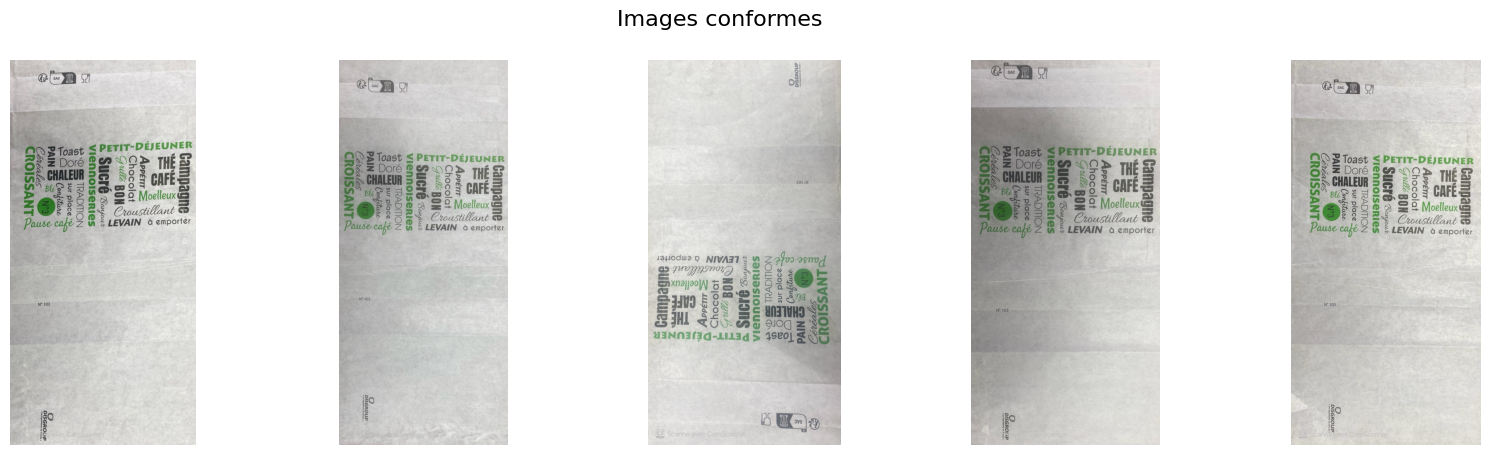

Affichage de 5 images non conformes :


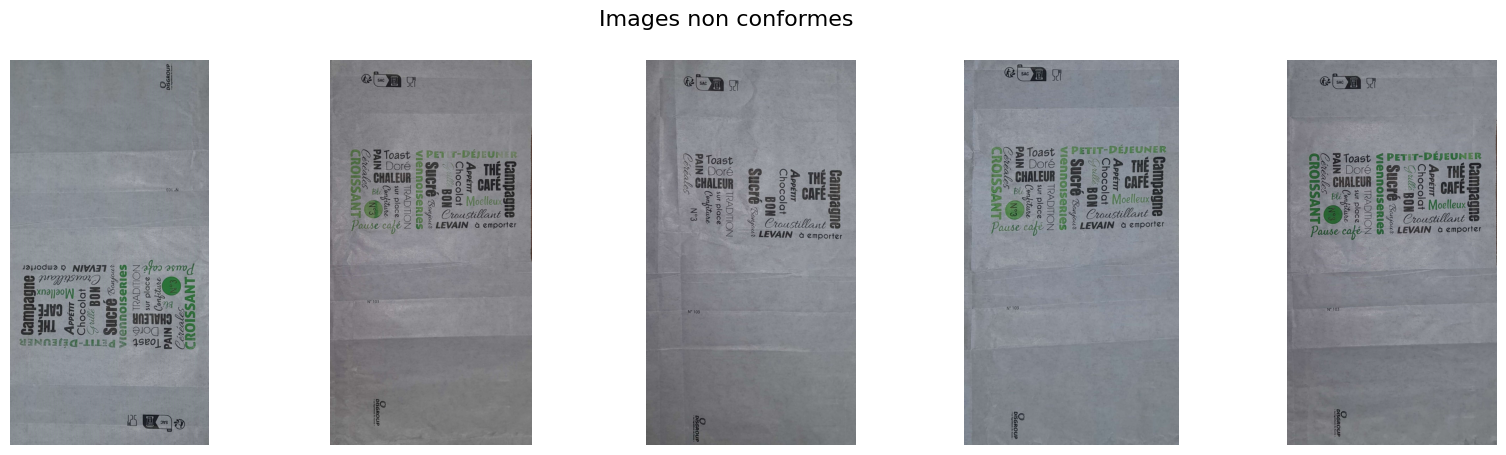

In [5]:

# 5 images conformes sur une ligne:
print("Affichage de 5 images conformes :")
display_random_images(conforme_dir, num_images=5, title="Images conformes")

# 5 images non conformes sur une ligne
print("Affichage de 5 images non conformes :")
display_random_images(non_conforme_dir, num_images=5, title="Images non conformes")


In [6]:
# la taille des images

print("Informations sur les images conformes :")
display_image_info(conforme_dir)

print("Informations sur les images non conformes :")
display_image_info(non_conforme_dir)

Informations sur les images conformes :
Nombre d'images dans le dossier /kaggle/input/data-projet/Data_project/Data_conforme: 276
Taille de l'image IMG_6118.JPG: 1240x2592 pixels
Taille de l'image IMG_6253.JPG: 1196x2592 pixels
Taille de l'image IMG_6209.JPG: 1176x2592 pixels
Taille de l'image IMG_6265.JPG: 1160x2592 pixels
Taille de l'image IMG_6312.JPG: 1256x2592 pixels
Taille de l'image IMG_6220.JPG: 1204x2592 pixels
Taille de l'image IMG_6262.JPG: 1152x2592 pixels
Taille de l'image IMG_6214.JPG: 1204x2592 pixels
Taille de l'image IMG_6307.JPG: 1168x2592 pixels
Taille de l'image IMG_6263.JPG: 1248x2592 pixels
Taille de l'image IMG_6348.JPG: 1216x2592 pixels
Taille de l'image IMG_6334.JPG: 1144x2592 pixels
Taille de l'image IMG_6175.JPG: 1288x2560 pixels
Taille de l'image IMG_6171.JPG: 1252x2592 pixels
Taille de l'image IMG_6174.JPG: 1236x2592 pixels
Taille de l'image IMG_6287.JPG: 1188x2592 pixels
Taille de l'image IMG_6154.JPG: 1248x2532 pixels
Taille de l'image IMG_6170.JPG: 1332x

In [7]:
# Déterminer la taille maximale des images conformes

max_conforme_size = get_max_image_size(conforme_dir)
print(f"Taille maximale des images conformes : {max_conforme_size}")

# Déterminer la taille maximale des images non conformes

max_non_conforme_size = get_max_image_size(non_conforme_dir)
print(f"Taille maximale des images non conformes : {max_non_conforme_size}")

# Déterminer la taille maximale globale
max_width = max(max_conforme_size[0], max_non_conforme_size[0])
max_height = max(max_conforme_size[1], max_non_conforme_size[1])
print(f"Taille maximale globale des images : ({max_width}, {max_height})")

Taille maximale des images conformes : (1332, 2592)
Taille maximale des images non conformes : (1710, 3431)
Taille maximale globale des images : (1710, 3431)


In [8]:
# Définir la taille des images et les paramètres de batch
img_height, img_width = 256, 256
batch_size = 32

# Obtenir la valeur maximale des pixels pour normaliser
max_pixel_value = 255.0  # Vous pouvez ajuster cela si nécessaire

# Initialiser l'ImageDataGenerator pour la normalisation et l'augmentation des données
datagen = ImageDataGenerator(
    rescale=1.0 / max_pixel_value,
    validation_split=0.2  # 20% des données seront utilisées pour la validation
)

# Générateur d'images d'entraînement
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Utiliser le sous-ensemble d'entraînement
)

# Générateur d'images de validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Utiliser le sous-ensemble de validation
)

Found 561 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


# Modeling

In [9]:
# créer une dataframe pour enregistrer les différentes métriques utilisées:

model_performance = pd.DataFrame(columns=['Training Time', 'train accuracy', 'test accuracy', 'train loss', 'test loss'])



## Modèle CNN

In [10]:
# Initialiser l'ImageDataGenerator pour la normalisation et l'augmentation des données
datagen = ImageDataGenerator(
    rescale=1.0 / max_pixel_value,
    validation_split=0.2,  # 20% des données seront utilisées pour la validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Définir un modèle CNN amélioré
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Définir les paramètres d'entraînement:
batch_size = 150
epochs = 5

# Entraîner le modèle
start_1 = time.time()
history_1 = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator)
end_train_1 = time.time()

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5270 - loss: 3.7307 - val_accuracy: 0.6143 - val_loss: 1.7836
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7071 - loss: 1.6381 - val_accuracy: 0.9500 - val_loss: 1.2801
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9181 - loss: 1.1332 - val_accuracy: 0.8000 - val_loss: 1.1014
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9795 - loss: 0.8000 - val_accuracy: 0.6214 - val_loss: 1.1778
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9919 - loss: 0.6545 - val_accuracy: 0.7214 - val_loss: 0.9955


In [12]:
# Évaluer le modèle sur l'ensemble d'entraînement:
Training_Time_1 = end_train_1 - start_1

print(f"la durée de l'entrainement: {Training_Time_1}")
print("")
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

la durée de l'entrainement: 412.9366991519928

18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6933 - loss: 1.0389
Train loss: 1.0095608234405518
Train accuracy: 0.698752224445343
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7314 - loss: 0.9908
Test loss: 0.9954862594604492
Test accuracy: 0.7214285731315613


In [13]:
# Enregistrement de modèle decision tree
model_performance.loc['CNN_1'] = [Training_Time_1, train_accuracy, test_accuracy, train_loss, test_loss]

In [14]:
model_performance.head()

,Training Time,train accuracy,test accuracy,train loss,test loss
CNN_1,412.936699,0.698752,0.721429,1.009561,0.995486


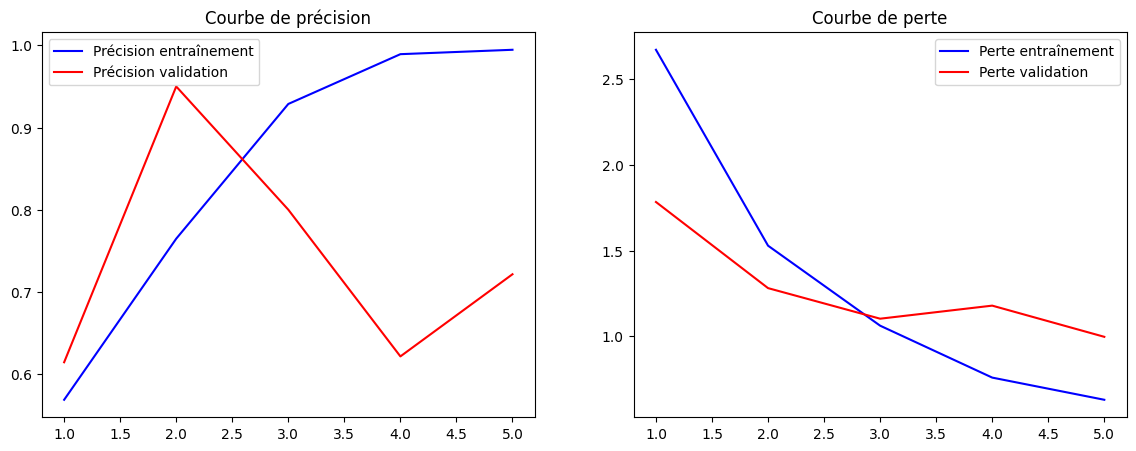

In [15]:
# Appeler la fonction pour affiche
plot_history(history_1)

In [16]:
# Sauvegarder le modèle complet
model.save('model_cnn.h5')

# Sauvegarder uniquement les poids du modèle
model.save_weights('model_cnn.weights.h5')

### Modèle 3 : VGG16

In [17]:
# Spécifiez le chemin local où vous avez enregistré le fichier des poids
weights_path = '/kaggle/input/weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [18]:
# Charger le modèle VGG16 pré-entraîné
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(img_height, img_width, 3))

# Congeler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches de classification
model_VGG = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model_VGG.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])



In [19]:
# Entraîner le modèle
start_3 = time.time()

history_VGG = model_VGG.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
end_train_3 = time.time()

Training_Time_3 = end_train_3 - start_3

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 279s 15s/step - accuracy: 0.5865 - loss: 0.6951 - val_accuracy: 0.8929 - val_loss: 0.4912
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 311s 15s/step - accuracy: 0.7519 - loss: 0.5372 - val_accuracy: 0.9857 - val_loss: 0.3518
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 268s 15s/step - accuracy: 0.8802 - loss: 0.4008 - val_accuracy: 0.9929 - val_loss: 0.2497
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 320s 15s/step - accuracy: 0.9009 - loss: 0.3074 - val_accuracy: 0.9929 - val_loss: 0.1894
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 266s 15s/step - accuracy: 0.9504 - loss: 0.2354 - val_accuracy: 0.9857 - val_loss: 0.1590
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 321s 15s/step - accuracy: 0.9482 - loss: 0.1938 - val_accuracy: 0.9929 - val_loss: 0.1214
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 265s 15s/step - accuracy: 0.9662 - loss: 0.1550 - val_accuracy: 0.9929 - val_loss: 0.1022
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 265s 15s/step - accuracy: 0.9737 - loss: 0.1227 - val_accuracy: 0.

In [20]:
# Évaluer le modèle sur les données de validation
validation_loss, validation_accuracy = model_VGG.evaluate(validation_generator)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.9868 - loss: 0.0696
Validation Accuracy: 99.29%


In [21]:
# Évaluer le modèle sur l'ensemble d'entraînement


print(f"la durée de l'entrainement: {Training_Time_3}")
print("")
train_loss, train_accuracy = model_VGG.evaluate(train_generator)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_VGG.evaluate(validation_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

la durée de l'entrainement: 2826.568493127823

18/18 ━━━━━━━━━━━━━━━━━━━━ 208s 12s/step - accuracy: 0.9940 - loss: 0.0916
Train loss: 0.08805777877569199
Train accuracy: 0.9893048405647278
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.9920 - loss: 0.0666
Test loss: 0.06671973317861557
Test accuracy: 0.9928571581840515


In [22]:
# Enregistrement de modèle decision tree
model_performance.loc['VGG16'] = [Training_Time_3, train_accuracy, test_accuracy, train_loss, test_loss]

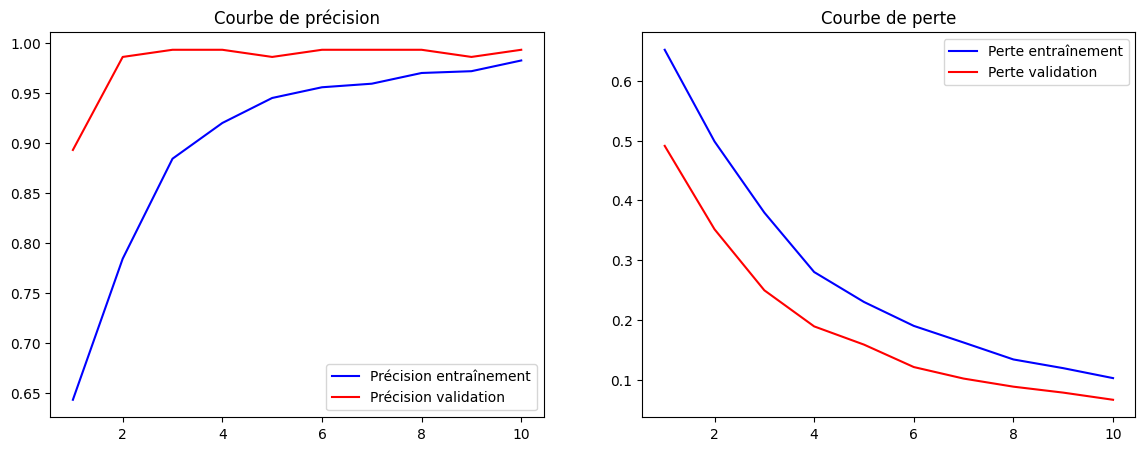

In [23]:
# Afficher les courbes de perte et de précision pendant l'entraînement
plot_history(history_VGG)

In [24]:
# Sauvegarder le modèle complet
model_VGG.save('model_VGG.h5')

# Sauvegarder uniquement les poids du modèle
model_VGG.save_weights('model_VGG.weights.h5')

### modèle 4: modèle resnet

In [25]:
# Charger le modèle ResNet50 pré-entraîné
resnet = "/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model_resnet = ResNet50(weights=resnet, include_top=False, input_shape=(img_height, img_width, 3))

# Congeler les couches du modèle de base
for layer in base_model_resnet.layers:
    layer.trainable = False

# Ajouter des couches de classification
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compiler le modèle
model_resnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Entraîner le modèle
start_4 = time.time()
history_resnet = model_resnet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
end_train_4 = time.time()

Training_Time_4 = end_train_4 - start_4

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.5450 - loss: 1.1489 - val_accuracy: 0.6071 - val_loss: 0.6509
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.5881 - loss: 0.7254 - val_accuracy: 0.3929 - val_loss: 0.6981
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.5976 - loss: 0.6807 - val_accuracy: 0.7929 - val_loss: 0.5404
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.7037 - loss: 0.5884 - val_accuracy: 0.8214 - val_loss: 0.5106
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.7382 - loss: 0.5603 - val_accuracy: 0.9286 - val_loss: 0.5012
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.7448 - loss: 0.5567 - val_accuracy: 0.8071 - val_loss: 0.4581
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.8102 - loss: 0.4839 - val_accuracy: 0.8143 - val_loss: 0.4280
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.7388 - loss: 0.5389 - val_accuracy: 0.9429 - val_lo

In [27]:
# Évaluer le modèle sur l'ensemble d'entraînement
print(f"la durée de l'entrainement: {Training_Time_4}")
print("")

train_loss, train_accuracy = model_resnet.evaluate(train_generator)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_resnet.evaluate(validation_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

la durée de l'entrainement: 1066.7069103717804

18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9378 - loss: 0.4802
Train loss: 0.47567400336265564
Train accuracy: 0.9322637915611267
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9514 - loss: 0.4465
Test loss: 0.45158466696739197
Test accuracy: 0.9428571462631226


In [28]:
# Enregistrement de modèle decision tree
model_performance.loc['Resnet'] = [Training_Time_4, train_accuracy, test_accuracy, train_loss, test_loss]

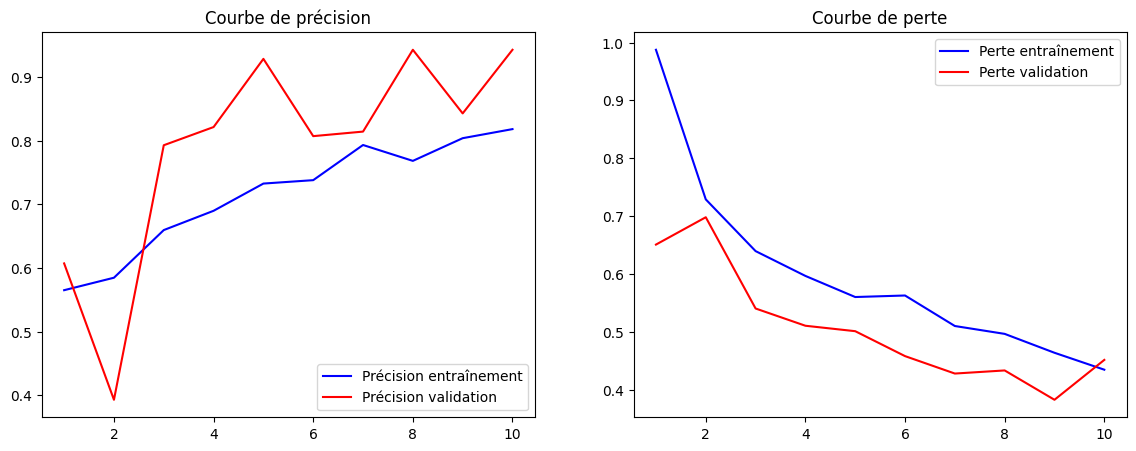

In [29]:
plot_history(history_resnet)

In [30]:
# Sauvegarder le modèle complet
model_resnet.save('model_resnet.h5')

#Sauvegarder uniquement les poids du modèle
model_resnet.save_weights('model_resnet.weights.h5')

### Modèle 5: Modèle InceptionV3

In [31]:
# Charger le modèle InceptionV3 pré-entraîné
IV3 = "/kaggle/input/iv3-modle/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model_IV3 = InceptionV3(weights=IV3, include_top=False, input_shape=(img_height, img_width, 3))

# Congeler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches de classification
model_IV3 = Sequential([
    base_model_IV3,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
model_IV3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# Entraîner le modèle
start_5 = time.time()
history_IV3 = model_IV3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)
end_train_5 = time.time()

Training_Time_5 = end_train_5 - start_5

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 251s 11s/step - accuracy: 0.7987 - loss: 0.5594 - val_accuracy: 0.6071 - val_loss: 9.6349
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 263s 11s/step - accuracy: 1.0000 - loss: 2.0125e-04 - val_accuracy: 0.6071 - val_loss: 9.4559
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 200s 11s/step - accuracy: 1.0000 - loss: 2.0406e-04 - val_accuracy: 0.6071 - val_loss: 3.2990
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 1.0000 - loss: 5.4941e-05 - val_accuracy: 0.7857 - val_loss: 0.4276
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 200s 11s/step - accuracy: 1.0000 - loss: 1.0010e-04 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 207s 11s/step - accuracy: 1.0000 - loss: 1.9052e-05 - val_accuracy: 1.0000 - val_loss: 2.2432e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 200s 11s/step - accuracy: 1.0000 - loss: 1.5217e-04 - val_accuracy: 1.0000 - val_loss: 5.7166e-05
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 201s 11s/step - accuracy: 0.9693 -

In [33]:
# Évaluer le modèle sur l'ensemble d'entraînement
print(f"la durée de l'entrainement: {Training_Time_5}")
print("")
train_loss, train_accuracy = model_IV3.evaluate(train_generator)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_IV3.evaluate(validation_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

la durée de l'entrainement: 2191.6737513542175

18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.3851 - loss: 559.3881
Train loss: 554.2456665039062
Train accuracy: 0.39393940567970276
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3961 - loss: 427.8140
Test loss: 423.752685546875
Test accuracy: 0.3928571343421936


In [34]:
# Enregistrement de modèle decision tree
model_performance.loc['Inception V3'] = [Training_Time_5, train_accuracy, test_accuracy, train_loss, test_loss]

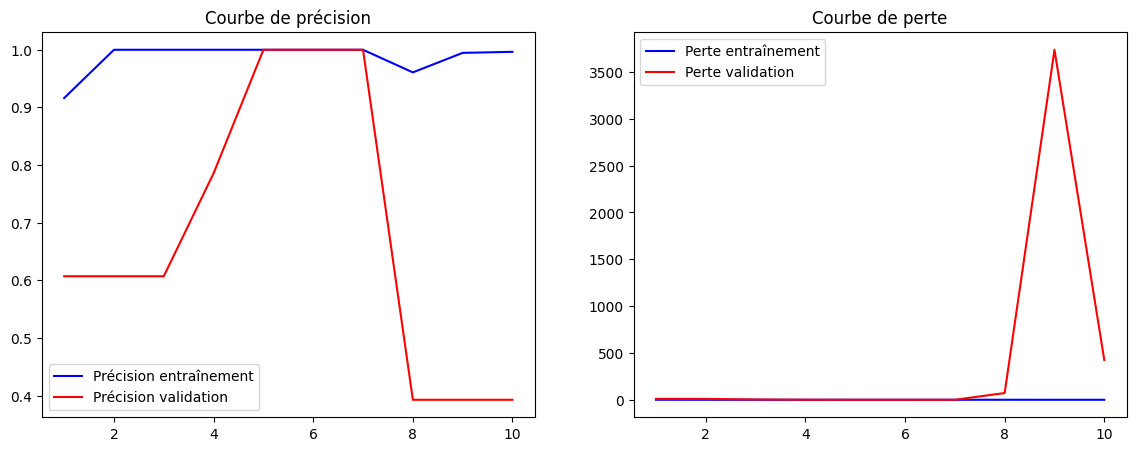

In [35]:
plot_history(history_IV3)

In [36]:
# Sauvegarder le modèle complet
model_IV3.save('model_IV3.h5')

# Sauvegarder uniquement les poids du modèle
model_IV3.save_weights('model_IV3.weights.h5')

## Emedding modèle:

In [37]:
# Utiliser ResNet50 pré-entraîné comme extracteur de caractéristiques
resnet = "/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = ResNet50(weights=resnet, include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
embeddings = Model(inputs=base_model.input, outputs=x)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

In [38]:
# Extraire les embeddings des images d'entraînement
train_embeddings = []
train_labels = []
for i in range(len(train_generator)):
    imgs, labels = train_generator.next()
    embs = embeddings.predict(imgs)
    train_embeddings.append(embs)
    train_labels.append(labels)
train_embeddings = np.concatenate(train_embeddings)
train_labels = np.concatenate(train_labels)

# Extraire les embeddings des images de validation
val_embeddings = []
val_labels = []
for i in range(len(validation_generator)):
    imgs, labels = validation_generator.next()
    embs = embeddings.predict(imgs)
    val_embeddings.append(embs)
    val_labels.append(labels)
val_embeddings = np.concatenate(val_embeddings)
val_labels = np.concatenate(val_labels)

AttributeError: 'DirectoryIterator' object has no attribute 'next'

In [ ]:
# Créer le modèle de classification
model_emb = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
    Dense(1, activation='sigmoid')
])

model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

 # Entraîner le modèle de classification
start_6 = time.time()
history_emb = model_emb.fit(train_embeddings, train_labels, epochs=150, batch_size=batch_size, validation_data=(val_embeddings, val_labels))
end_train_6 = time.time()

Training_Time_6 = end_train_6 - start_6

In [ ]:
# Évaluer le modèle sur l'ensemble d'entraînement
print(f"la durée de l'entrainement: {Training_Time_6}")
print("")

train_loss, train_accuracy = model_emb.evaluate(train_embeddings, train_labels)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_emb.evaluate(val_embeddings, val_labels)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [ ]:
# Enregistrement de modèle decision tree
model_performance.loc['Embedding '] = [Training_Time_6, train_accuracy, test_accuracy, train_loss, test_loss]

In [ ]:
plot_history(history_emb)

In [ ]:
# Sauvegarder le modèle complet
model_emb.save('model_emb.h5')

# Sauvegarder uniquement les poids du modèle
model_emb.save_weights('model_emb.weights.h5')